<a href="https://colab.research.google.com/github/lcipolina/escher/blob/Lucia/ML/ImagePainterNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Painter
The aim of this notebook is to:

* Load a picture
* Create a feed-forward Neural Network
* Use the NN to "learn" the picture as a colour (RGB) distribution over the (x,y) pixel coordinates
* Use the trained NN to "paint back" the original picture

Is this overfitting? Yes! So what's the value added?

The value added is that (hopefully) what we will have achieved is a compact (in terms of parameters needed to be saved on disk) approximator of any given picture!

## Import packages preamble

In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import time
from IPython.display import clear_output
import tensorflow as tf
from tensorflow import keras
import skimage
from PIL import Image

### Function definitions

In [2]:
def create_NN_2(nnodes):
    ### This function neatly wraps the construction of the NN
    # It returns a Keras TF model
    
    # Inputs are X, Y coordinates
    ninputs = 2
    # Outputs are the R, G, B channels for the desired pixel
    noutputs = 3
    
    model = tf.keras.models.Sequential()
    
    # All RELU
    model.add(tf.keras.Input(shape=(ninputs,)))
    model.add(tf.keras.layers.Dense(nnodes, activation='relu'))
    model.add(tf.keras.layers.Dense(nnodes, activation='relu'))
    model.add(tf.keras.layers.Dense(nnodes, activation='relu'))
    model.add(tf.keras.layers.Dense(nnodes, activation='relu'))
    model.add(tf.keras.layers.Dense(nnodes, activation='relu'))
    model.add(tf.keras.layers.Dense(noutputs))
    
    # 5 Leaky RELU
    #lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.05)
    #model.add(tf.keras.Input(shape=(ninputs,)))
    #model.add(tf.keras.layers.Dense(nnodes, activation=lrelu))
    #model.add(tf.keras.layers.Dense(nnodes, activation=lrelu))
    #model.add(tf.keras.layers.Dense(nnodes, activation=lrelu))
    #model.add(tf.keras.layers.Dense(nnodes, activation=lrelu))
    #model.add(tf.keras.layers.Dense(nnodes, activation=lrelu))
    #model.add(tf.keras.layers.Dense(noutputs))
    
    return model

In [3]:
def get_image_array_from_numpy(numpy_array,
                              height,
                              width):
    # Matplotlib, in order to show the image, requires to convert back the NN prediction from a Numpy array to a list of lists
    # In particular, note how the list of lists is indexed by 1) The Y coordinate 2) The X coordinate, not X and then Y!

    new_image = []

    for y in range(0, height):
        new_image.append([])
        for x in range(0, width):
            new_image[y].append(numpy_array[y + height * x].tolist())
            new_image[y][x] = [int(i) for i in new_image[y][x]]
            
    return new_image


### Load image

In [4]:
# upload files from disk
from google.colab import files
uploaded = files.upload()

  

Saving escher_original.jpg to escher_original.jpg


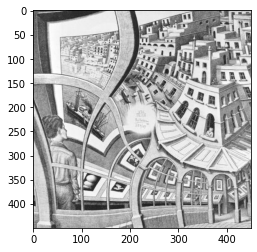

In [5]:
filename = "Pics/escher.png"#"Pics/fender.png"
fname = next(iter(uploaded)) #Get the file's name
image = cv2.imread(fname)
plt.imshow(image)
plt.show()

### Convert raw image in X and Y inputs for the NN

In [6]:
# The X input for the NN is a tuple of (x,y) pixel coordinates
# The Y input is the (r, g, b) tuple

height = len(image)
width = len(image[0])

# X (coordinates) and Y (rgb) data
X = []
Y = []

# The idea is to:
# 1) Loop over the x and y coordinates of the picture
# 2) Save the (x, y) tuple and the RGB tuple in the separate lists
for x in range(0, width):
    for y in range(0, height):
        X.append((x, y))
        Y.append(image[y][x])

# The last step is to transform the x and y lists as Numpy arrays
# This is necessary to feed the Keras model
x_np = np.asarray(X)
y_np = np.asarray(Y)

### Create Keras NN

In [7]:
num_nodes = 2000
model = create_NN_2(num_nodes)
model.compile(loss=tf.keras.losses.MeanSquaredError(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
              metrics=['accuracy'])

### Train the Keras NN

In [8]:
model.fit(x_np, y_np, epochs=1000, batch_size=1000, shuffle = True)

Epoch 1/1000
203/203 [==============================] - 6s 18ms/step - loss: 23881560.1903 - accuracy: 0.4315
Epoch 2/1000
203/203 [==============================] - 4s 18ms/step - loss: 5041.9141 - accuracy: 0.3149
Epoch 3/1000
203/203 [==============================] - 4s 18ms/step - loss: 3262.0765 - accuracy: 0.3332
Epoch 4/1000
203/203 [==============================] - 4s 18ms/step - loss: 3082.7510 - accuracy: 0.3784
Epoch 5/1000
203/203 [==============================] - 4s 18ms/step - loss: 2989.0342 - accuracy: 0.3183
Epoch 6/1000
203/203 [==============================] - 4s 18ms/step - loss: 2945.9333 - accuracy: 0.2901
Epoch 7/1000
203/203 [==============================] - 4s 18ms/step - loss: 2929.1959 - accuracy: 0.3225
Epoch 8/1000
203/203 [==============================] - 4s 18ms/step - loss: 2820.3003 - accuracy: 0.3134
Epoch 9/1000
203/203 [==============================] - 4s 18ms/step - loss: 2888.7918 - accuracy: 0.3315
Epoch 10/1000
203/203 [===================

### Obtain the "painted" picture according to the NN
Note that this is equivalent to asking for a "prediction" of the RGB tuple for every pixel coordinate of the original image.

If you are not convinced, look at the fact that we are calling _model.predict(x_np)_, where _x_np_ is the same X input vector we have provided during training, i.e. spanning the whole picture.

In [9]:
image_according_to_nn = model.predict(x_np)

In [10]:
new_image = get_image_array_from_numpy(image_according_to_nn,
                                       height,
                                       width)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


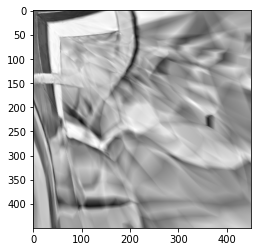

In [11]:
# Let's show the picture!
plt.imshow(new_image)

### Save model weights (optional)

In [ ]:
model.save_weights("model_weights_escher_1800_epochs.mw")

### Extrapolation test

In [ ]:
# The offset is the amount of pixels that we want to extrapolate from each side of the original painting
offset = 25

# Height_1 and width_1 are the height and width respectively of the extrapolated picture
# Note that, in order to guarantee extrapolation on each side, we add offset * 2 to the original height and width
height_1 = height + offset * 2
width_1 = width + offset * 2
x_1 = []

# The idea is to create a (x, y) series of tuple in such a way that 
# the NN will be "forced" to extrapolate outside of the known region
for x in range(0, width_1):
    for y in range(0, height_1):
        # We subtract the offset, so that in the center of the new picture we should get the "normal" picture only!
        x_1.append((x - offset, y - offset))

# The last step is to transform the x and y lists as Numpy arrays
# This is necessary to feed the Keras model
x_1_np = np.asarray(x_1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


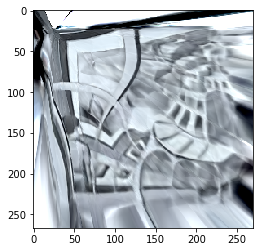

In [ ]:
# The extrapolated picture is obtained exactly like the "normal" one, i.e. by asking a prediction to the NN
# However, this time we will ask the NN to span a larger space, outside of what the NN has trained itself on
extrapolated_image_np = model.predict(x_1_np)
extrapolated_image = get_image_array_from_numpy(extrapolated_image_np,
                                       height_1,
                                       width_1)

# Let's show the extrapolated picture!
plt.imshow(extrapolated_image)